In [ ]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 7.1.1. Скачиваем CIFAR-10

Как мы и намеревались сделать, давайте импортируем torchvision и воспользуемся модулем datasets для скачивания данных CIFAR-10:

In [ ]:
from torchvision import datasets

In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Книга по PyTorch/data'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


# 7.1.2. Класс Dataset

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

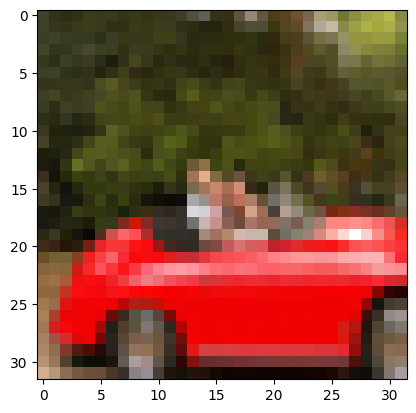

In [ ]:
plt.imshow(img)
plt.show()

# 7.1.3. Преобразования объектов Dataset

Все это хорошо, но нам нужно преобразовать изображение PIL в тензор PyTorch,
чтобы с ним что-то делать. Тут нам пригодится модуль torchvision.transforms,
где описан набор компонуемых и подобных функциям объектов, которые можно передавать в качестве аргументов в наборы данных torchvision, например
datasets.CIFAR10(…), и преобразовывать данные после их загрузки, но перед
возвратом их методом __getitem__. Вот список доступных объектов:

In [ ]:
from torchvision import transforms

In [ ]:
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

Среди этих преобразований можно заметить ToTensor, превращающее массивы
NumPy и изображения PIL в тензоры. Оно также располагает измерения выходного тензора в порядке C × H × W (каналы, высота, ширина; точно как у нас
в главе 4).
Попробуем преобразование ToTensor в действии. После создания экземпляра
его можно вызвать как обычную функцию, передав изображение PIL в качестве
аргумента, и получить в качестве результата тензор:

In [ ]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

Как мы и предполагали, можно передать это преобразование непосредственно
в виде аргумента dataset.CIFAR10:


In [ ]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

Теперь при обращении к элементу набора данных будет возвращаться тензор,
а не изображение PIL:

In [ ]:
img_t, _= tensor_cifar10[99]

In [ ]:
img_t.shape

torch.Size([3, 32, 32])

In [ ]:
img_t.shape

torch.Size([3, 32, 32])

Если значения в исходном изображении PIL находились в диапазоне от 0 до 255
(8 бит на канал), то ToTensor преобразует данные в 32-битные значения с плавающей запятой на канал, масштабируя их к диапазону от 0,0 до 1,0. Проверим это:

In [ ]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

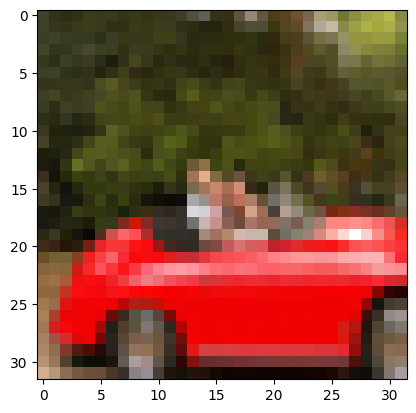

In [ ]:
plt.imshow(img_t.permute(1, 2, 0)) # Порядок осей координат меняется с C × H × W на H × W × C
plt.show()

# 7.1.4. Нормализация данных

Преобразования очень удобны, поскольку их можно организовывать цепочкой
с помощью transforms.Composeи они обеспечивают четкую и ясную нормализацию
224 Часть I. Основы PyTorch
и дополнение данных непосредственно при их загрузке

Поскольку набор данных CIFAR-10 невелик, можно работать с ним полностью
в оперативной памяти. Разместим все возвращаемые объектом Dataset тензоры
последовательно в дополнительном измерении:

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)

In [ ]:
tensor_cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Colab Notebooks/Книга по PyTorch/data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

Вычислив эти значения, мы можем произвести преобразование Normalize:

In [ ]:
transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.2435, 0.2616))

In [ ]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
]))

In [ ]:
img_t, _ = transformed_cifar10[99]

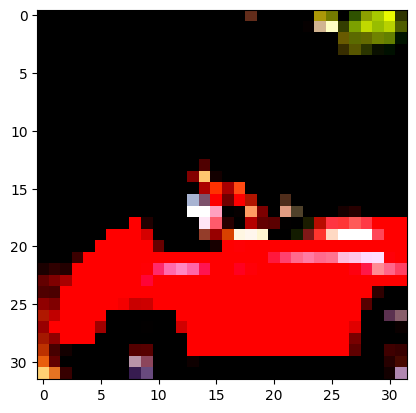

In [ ]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()

Итак, мы загрузили интересный набор данных с десятками тысяч изображений!
Очень удобно, поскольку нам как раз что-то подобное и понадобится.

# 7.2. Различаем птиц и самолеты

Джейн, наш друг из орнитологического клуба, установила в лесу к югу от аэропорта множество камер, которые автоматически делают снимок, когда что-то
попадает в кадр, и загружают в работающий в реальном времени блог наблюдения за птицами. Проблема в том, что камеры срабатывают на множество самолетов, прилетающих в аэропорт и вылетающих из него. Поэтому Джейн тратит
немало времени на удаление из блога фотографий самолетов. Ей необходима
автоматизированная система вроде той, что показана на рис. 7.6. Вместо того
чтобы удалять фотографии вручную, она хотела бы воспользоваться нейронной
сетью — искусственным интеллектом, говоря языком маркетологов, — чтобы
сразу же отфильтровывать самолеты.

Легко! Будет сделано без проблем — у нас как раз есть идеальный набор данных
для этой цели (какое совпадение, правда?). Мы выберем всех птиц и самолеты
из нашего набора данных CIFAR-10 и создадим нейронную сеть, способную их
различать между собой.

# 7.2.1. Формирование набора данных

Первый этап — приведение данных в правильную форму. Мы создадим подкласс Dataset, включающий только птиц и самолеты. Однако набор данных мал,
и для работы с ним нам нужен лишь доступ по индексу и len. Так что вовсе не
обязательно делать подкласс torch.utils.data.dataset.Dataset! Почему бы не
упростить себе задачу и просто фильтровать данные из cifar101
, перераспределив
метки так, чтобы они остались непрерывными? Вот так:


In [ ]:
cifar10 = datasets.CIFAR10(data_path, train=True, download=False,
                           transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                  (0.2470, 0.2435, 0.2616))
]))


cifar10_val = datasets.CIFAR10(data_path, train=False, download=False,
                           transform=transforms.Compose([
                              transforms.ToTensor(),
                              transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                  (0.2470, 0.2435, 0.2616))
]))

In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in cifar10_val if label in [0, 2]]

Объект cifar2 удовлетворяет основным требованиям к Dataset — в нем описаны
методы __len__ и __getitem__, — так что мы можем им воспользоваться. Впрочем,
осторожнее, мы тут «срезаем углы» с соответствующими ограничениями, так что,
возможно, в некоторых случаях имеет смысл реализовать полноценный Dataset
.

# 7.2.2. Полносвязная модель

In [ ]:
n_out = 2

model = nn.Sequential(
    nn.Linear(3*32*32, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.Softmax(dim=1)
)

# 7.2.4. Представление выходного сигнала в качестве вероятностей

In [ ]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

In [ ]:
x = torch.tensor([1.0, 2.0, 3.0])
softmax(x)

tensor([0.0900, 0.2447, 0.6652])

In [ ]:
softmax(x).sum()

tensor(1.)

In [ ]:
softmax = nn.Softmax(dim=1)

In [ ]:
x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

Можно даже попробовать модель в работе, прежде чем ее обучать. Давайте попробуем, просто чтобы посмотреть, что получится. Сначала сформируем батч
из одного изображения, птицы

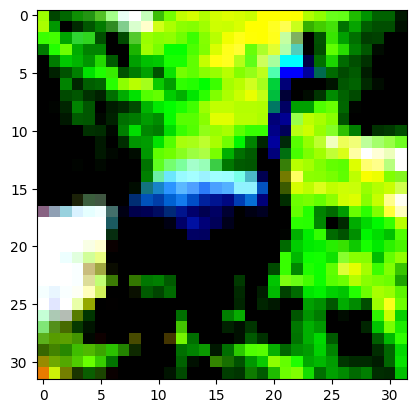

In [ ]:
img, _ = cifar2[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
img_batch = img.view(-1).unsqueeze(0)

In [ ]:
img_batch

tensor([[ 0.6143, -0.3224, -0.1160,  ..., -1.2721, -1.3170, -1.0472]])

In [ ]:
out = model(img_batch)

In [ ]:
out

tensor([[0.5463, 0.4537]], grad_fn=<SoftmaxBackward0>)

In [ ]:
_, index = torch.max(out, dim=1)

In [ ]:
index

tensor([0])

# 7.2.5. Функция потерь для классификации

Подытоживая, нашу функцию потерь для классификации можно вычислить
следующим образом. Для каждого примера данных в батче мы делаем следующее.
1. Производим прямой проход и получаем выходные значения из последнего
(линейного) слоя.
2. Вычисляем для них многомерную логистическую функцию и получаем
вероятности.
3. Извлекаемпредсказанную вероятность для истинного класса (правдоподобие
параметров). Отметим, что истинный класс известен, поскольку обучение
производится с учителем, — это наши эталонные данные.
4. Вычисляем ее логарифм, ставим перед ним знак «минус» и прибавляем
к потерям.

Итак, как же проделать вышеописанное в PyTorch? В PyTorch есть класс
nn.NLLLoss. Впрочем (внимание, подводный камень!), он принимает на входе
не вероятности, как можно ожидать, а тензор логарифмов вероятностей. А затем вычисляет для батча данных NLL нашей модели. Для такого соглашения
о входных данных есть веские основания: когда вероятность близка к нулю,
вычисление ее логарифма связано со сложностями. Выходом из ситуации будет
воспользоваться функцией nn.LogSoftmax вместо nn.Softmax, которая обеспечивает численную устойчивость вычислений.

In [ ]:
model = nn.Sequential(
    nn.Linear(32*32*3, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

loss = nn.NLLLoss()

Функция потерь получает на входе выходной сигнал nn.LogSoftmax с батчем
в качестве первого аргумента и тензором индексов классов (нулей и единиц
в нашем случае) — в качестве второго. Проверим его на нашей птичке1
:

In [ ]:
out = model(img.view(-1).unsqueeze(0))

In [ ]:
loss(out, torch.tensor([label]))

tensor(0.8565, grad_fn=<NllLossBackward0>)

# 7.2.6. Обучение классификатор

In [ ]:
import torch.optim as optim

In [ ]:
model = nn.Sequential(
    nn.Linear(3*32*32, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

In [ ]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 100
loss_fn = nn.NLLLoss()

In [ ]:
# for epoch in range(1, num_epochs+1):
#     for img, label in cifar2:
#         out = model(img.view(-1).unsqueeze(0))
#         loss = loss_fn(out, torch.tensor([label]))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

В нашем коде обучения размер мини-батчей составляет 1 — мы выбираем по
одному элементу из набора данных за раз. Модуль torch.utils.data включает
класс, помогающий с перетасовкой и организацией данных по мини-батчам:
DataLoader. Задача загрузчика данных состоит в выборе мини-батчей из набора
данных с гибкими возможностями использования различных стратегий выборки. Одна из самых распространенных стратегий: равномерная выборка после
перетасовки данных в каждой эпохе. На рис. 7.14 показан загрузчик данных,
перетасовывающий полученные от Dataset индексы.

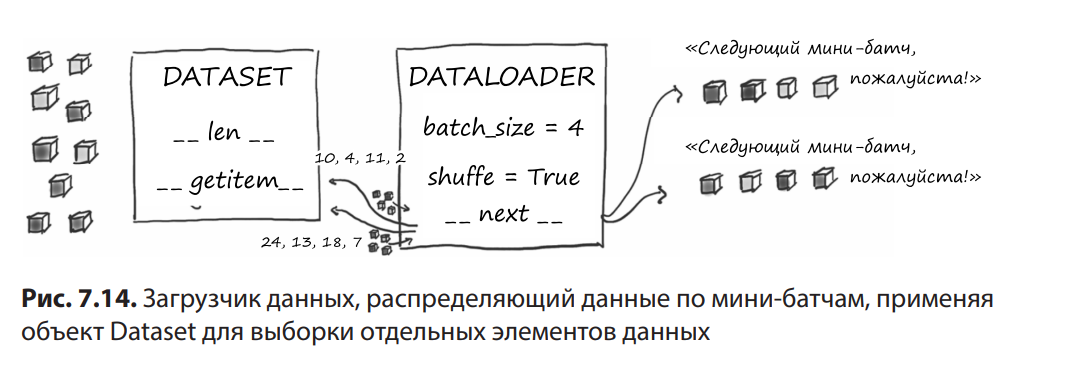

Взглянем, как это происходит. Как минимум конструктору класса DataLoader
необходимо передать объект Dataset, а также аргумент batch_size и булево
значение shuffle, указывающее, необходимо ли перетасовывать данные в начале каждой эпохи:

In [95]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

По объекту DataLoader можно проходить в цикле, поэтому мы можем использовать его непосредственно во внутреннем цикле нашего нового кода обучения:

In [111]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3*32*32, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1)
)

learining_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learining_rate)
num_epochs = 100
loss_fn = nn.NLLLoss()

for epoch in range(1, num_epochs+1):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch: %d, Loss: %f' % (epoch, float(loss)))

Epoch: 1, Loss: 0.531442
Epoch: 2, Loss: 0.616332
Epoch: 3, Loss: 0.527130
Epoch: 4, Loss: 0.445473
Epoch: 5, Loss: 0.492591
Epoch: 6, Loss: 0.373555
Epoch: 7, Loss: 0.557672
Epoch: 8, Loss: 0.537049
Epoch: 9, Loss: 0.374352
Epoch: 10, Loss: 0.566000
Epoch: 11, Loss: 0.378419
Epoch: 12, Loss: 0.651018
Epoch: 13, Loss: 0.453424
Epoch: 14, Loss: 0.504586
Epoch: 15, Loss: 0.455436
Epoch: 16, Loss: 0.155294
Epoch: 17, Loss: 0.330726
Epoch: 18, Loss: 0.627006
Epoch: 19, Loss: 0.181951
Epoch: 20, Loss: 0.183159
Epoch: 21, Loss: 0.113218
Epoch: 22, Loss: 0.268543
Epoch: 23, Loss: 0.270010
Epoch: 24, Loss: 0.175430
Epoch: 25, Loss: 0.187791
Epoch: 26, Loss: 0.168210
Epoch: 27, Loss: 0.150449
Epoch: 28, Loss: 0.258955
Epoch: 29, Loss: 0.171895
Epoch: 30, Loss: 0.140268
Epoch: 31, Loss: 0.116867
Epoch: 32, Loss: 0.190239
Epoch: 33, Loss: 0.281228
Epoch: 34, Loss: 0.210462
Epoch: 35, Loss: 0.181209
Epoch: 36, Loss: 0.609388
Epoch: 37, Loss: 0.188748
Epoch: 38, Loss: 0.703677
Epoch: 39, Loss: 0.06

Мы видим, что функция потерь убывает, но мы не знаем, достаточно ли низко
ее значение. А поскольку наша цель тут в том, чтобы правильно присвоить изображениям метки классов, причем желательно на независимом наборе данных,
мы можем вычислить безошибочность нашей модели на проверочном наборе
данных в контексте отношения количества правильных классификаций к общему их числу

In [114]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
     for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total+=labels.shape[0]
        correct+=int((predicted == labels).sum())

print("Accuracy:", correct / total)

Accuracy: 0.7955


In [179]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = nn.Sequential(
    nn.Linear(3*32*32, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
)

learining_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learining_rate)
num_epochs = 100
loss_fn = nn.MSELoss()

for epoch in range(1, num_epochs+1):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch: %d, Loss: %f' % (epoch, float(loss)))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: ignored

PyTorch позволяет быстро выяснить, сколько параметров у модели, с помощью
метода parameters() объекта nn.Model (тот же самый метод, с помощью которого
мы передавали параметры оптимизатору). Чтобы узнать, сколько элементов
в каждом из экземпляров тензоров, можно вызвать метод numel. Их суммирование
покажет нам общее количество. В зависимости от сценария использования, при
подсчете параметров может потребоваться проверить, установлен ли параметр
requires_grad в True, чтобы отделить количество обучаемых параметров от
общего размера модели. Взглянем на нашу текущую ситуацию:

In [117]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

Ничего себе, 3,7 миллиона параметров! Немаленькая сеть для такого маленького
входного изображения, правда?


# HomeWork
7.4. Упражнения
1. Реализуйте с помощью torchvision случайную обрезку изображений.

  А. Чем полученные изображения отличаются от необрезанных оригиналов?

  Б. Что будет, если запросить то же изображение во второй раз?

  В. Что получится в результате обучения на обрезанных случайным образом
изображениях?

2. Воспользуйтесь другой функцией потерь (например, MSE).

  А. Как изменится поведение при обучении?
3. Можно ли сократить разрешающие возможности сети так, чтобы она перестала переобучаться?

  А. Как при этом ведет себя модель на проверочном множестве?

In [156]:
from PIL import Image

In [175]:
image = Image.open('/content/photo_2023-10-06_22-16-49.jpg')

In [176]:
cropper = transforms.RandomCrop(size=(512, 512))

In [177]:
img_crop = cropper(image)

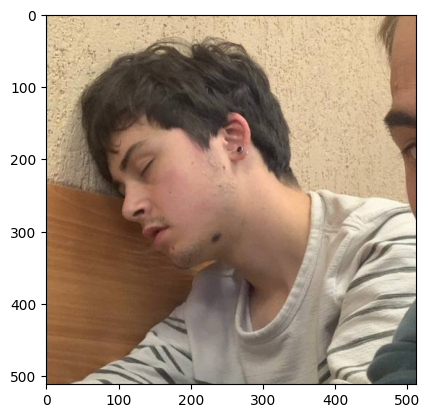

In [178]:
plt.imshow(img_crop)
plt.show()